In [1]:
import tensorflow as tf
from tensorflow.keras import layers as tl
from tensorflow.data import Dataset
import tensorflow_datasets as tfds
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def diffusion_f(t, T, s):
    return np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2

def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T+1) # additional slot for t = 0 [0, 1, 2, ..., T]
    f = diffusion_f(t, T, s)  # [f(0), f(1), f(2), ..., f(T)]
    
    alpha = np.clip(f[1:]/f[:-1], 1 - max_beta, 1) # calculate alpha and clip the value for min: 1-max_beta, max: 1
    alpha = np.append(1, alpha).astype(np.float32) # insert alpha0
    beta = 1 - alpha
    alpha_overline = np.cumprod(alpha)

    return alpha, alpha_overline, beta

    
    

In [48]:
T = 4000
alpha, alpha_overline, beta = variance_schedule(T)

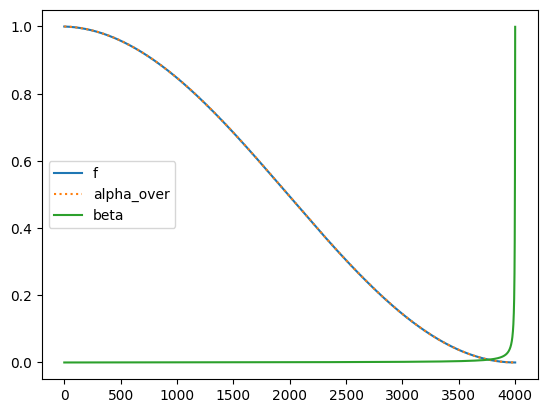

In [28]:
t = np.arange(T+1)

f = diffusion_f(t, T, 0.008)

plt.plot(t, f, label='f')
plt.plot(t, alpha_overline, label='alpha_over', linestyle=':')
plt.plot(t, beta, label='beta')
plt.legend()

plt.show()

In [201]:

def prepare_batch_factory(T, alpha_overline):
    def prepare_batch(X): # values in X should be between 0 ~ 1
        X = X * 2 - 1  # X would be between -1 ~ 1 (similar to gauss normal distribution)
        X_shape = tf.shape(X)
        if len(X_shape) == 3:
            X = tf.cast(X[..., tf.newaxis], tf.float32) # new axis for channel layer
        else:
            X = tf.cast(X, tf.float32)
        
        t = tf.random.uniform([X_shape[0]], minval=1, maxval=T+1, dtype=tf.int32) # t between 1 ~ T
        alpha_o = tf.cast(tf.gather(alpha_overline, t), dtype=tf.float32)
        alpha_o = tf.reshape(alpha_o, [X_shape[0]] + [1] * (len(X_shape)-1))  # reshape to [batch_size, 1, 1, 1] for broadcasting
        noise = tf.random.normal(X_shape) # noise with avg = 0, std = 1
    
        X_at_t = (alpha_o ** 0.5) * X + ((1 - alpha_o) ** 0.5) * noise
    
        return {'time': t, 'X_noisy': X_at_t}, noise
    return prepare_batch

def normalize_image(X):
    return tf.cast(X, dtype=tf.float32) / 255.0
    

In [202]:
sprites_file_path = 'assets/sprite/sprites_1788_16x16.npy'
sprites = np.load(sprites_file_path)


89400 uint8


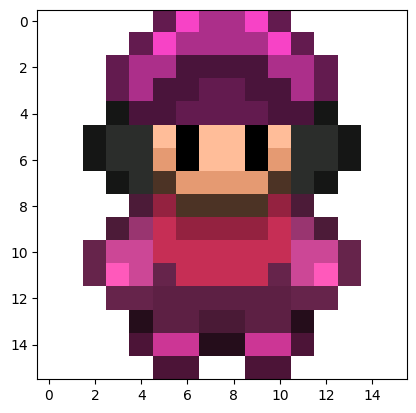

In [203]:
print(len(sprites), sprites.dtype)
plt.imshow(sprites[0])

In [204]:


def prepare_dataset(X, T, batch_size=32, shuffle=False):
    _, alpha_overline, _ = variance_schedule(T)
    prepare_batch = prepare_batch_factory(T, alpha_overline)
    ds = Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(buffer_size=int(len(X) * 0.9))
    return ds.batch(batch_size).map(normalize_image).map(prepare_batch).prefetch(1)
    # return ds.batch(batch_size).map(normalize_image).prefetch(1)

train_set = prepare_dataset(sprites, T, batch_size=32, shuffle=True)

In [205]:
sample = train_set.take(1)

In [206]:
print(sample)

<_TakeDataset element_spec=({'time': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'X_noisy': TensorSpec(shape=(None, 16, 16, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 16, 16, 3), dtype=tf.float32, name=None))>


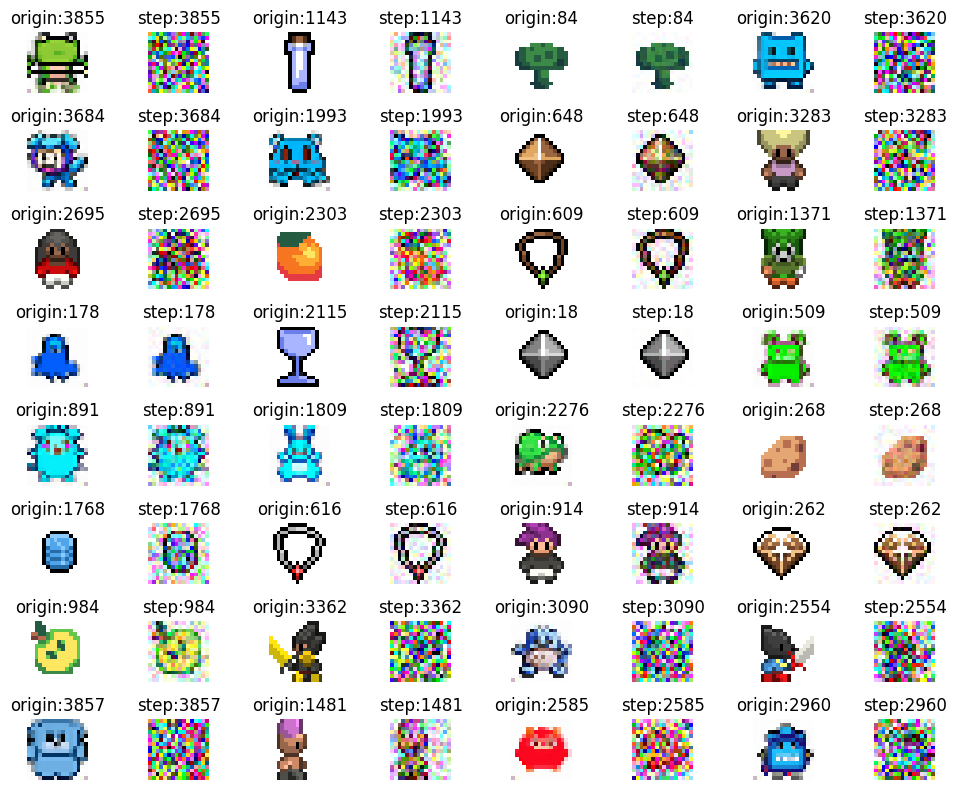

In [207]:
sample, sample_noise = list(sample)[0]
sample_t, sample_X = sample['time'], sample['X_noisy']
# there is value < -1.0 and > 1.0. clipping is required to recover.

fig, axs = plt.subplots(8, 8, figsize=[10,8])

def normal_to_image(X):
    return tf.clip_by_value(tf.cast((X + 1.0) / 2.0 * 255.0, dtype=tf.int16), 0, 255)

def substract_noise(X_noisy, t, noise):
    _, alpha_overline, _ = variance_schedule(T)
    X_shape = tf.shape(X_noisy)
    alpha_o = tf.cast(tf.gather(alpha_overline, t), dtype=tf.float32)
    alpha_o = tf.reshape(alpha_o, [X_shape[0]] + [1] * (len(X_shape)-1))
    
    # reverse of (alpha_o ** 0.5) * X + ((1 - alpha_o) ** 0.5) * noise
    return (X_noisy - ((1 - alpha_o) ** 0.5) * noise) / (alpha_o ** 0.5)

recovered_images = substract_noise(sample_X, sample_t, sample_noise)

for i in range(len(sample_t)):
    image = normal_to_image(sample_X[i])
    recovered_image = normal_to_image(recovered_images[i])
    
    # print(recovered_image)
    axs[(2*i) // 8, (2*i) % 8].imshow(recovered_image)
    axs[(2*i) // 8, (2*i) % 8].set_title(f'origin:{tf.keras.backend.get_value(sample_t[i])}')
    axs[(2*i) // 8, (2*i) % 8].axis('off')

    axs[(2*i) // 8, (2*i) % 8 + 1].imshow(image)
    axs[(2*i) // 8, (2*i) % 8 + 1].set_title(f'step:{tf.keras.backend.get_value(sample_t[i])}')
    axs[(2*i) // 8, (2*i) % 8 + 1].axis('off')
    

plt.tight_layout()


In [212]:
class TimeEncoding(tl.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 ==0, 'embed size must be even number'
        p, i = np.meshgrid(np.arange(T+1), 2 * np.arange(embed_size // 2))
        pos_emb = np.empty((T+1, embed_size)) # T X d_emb 
        pos_emb[:, ::2] = np.sin(p / (10_000 ** (i / embed_size))).T
        pos_emb[:, 1::2] = np.cos(p / (10_000 ** (i / embed_size))).T
        self.time_encodings = tf.constant(pos_emb.astype(self.dtype)) # numpy.empty는 기본적으로 float64로 만들기 때문에 float32 이하를 tensorflow에서 사용하기 위해서는 type 변경이 필오하다.
        # self.supports_masking = True # mask propabation for next layer

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs) # shape: (batch, d_emb)


In [225]:
def build_diffusion_model(input_shape, T, embed_size):
    X_noisy = tl.Input(shape=input_shape, name='X_noisy')
    time_input = tl.Input(shape=[], dtype=tf.int32, name='time')
    time_enc = TimeEncoding(T, embed_size)(time_input) # batch_size X embed_size

    dim = 16
    Z = tl.Conv2D(dim, 3, padding='same')(X_noisy)
    Z = tl.BatchNormalization()(Z)
    Z = tl.Activation('relu')(Z)

    time_Z = tl.Dense(dim)(time_enc)
    Z = time_Z[:, tf.newaxis, tf.newaxis, :] + Z # time_Z shape: batch_size X 1 X 1 X dim
    
    skip = Z
    cross_skips = [] # UNet's skip connection betwwen down sampling and upsampling
    Z = tl.Activation('relu')(Z)
    
    for dim in (32, 64, 128):
        # inception with keeping size
        Z = tl.SeparableConv2D(dim, 3, padding='same')(Z)
        Z = tl.BatchNormalization()(Z)
        Z = tl.Activation('relu')(Z)

        # inception with keeping size
        Z = tl.SeparableConv2D(dim, 3, padding='same')(Z)
        Z = tl.BatchNormalization()(Z)
        Z = tl.Activation('relu')(Z)

        cross_skips.append(Z)

        Z = tl.MaxPooling2D(3, strides=2, padding='same')(Z) # half-size
        skip_link = tl.Conv2D(dim, 1, strides=2, padding='same')(skip) # half-size

        Z = tl.Add()([Z, skip_link])

        time_Z = tl.Dense(dim)(time_enc)
        Z = time_Z[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    output = Z

    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[output])

model = build_diffusion_model([16, 16, 3], 500, 64)

plot_model(model, to_file='assets/
        

    
    

    
    
    

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 time (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 X_noisy (InputLayer)        [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 time_encoding_13 (TimeEnco  (None, 64)                   0         ['time[0][0]']                
 ding)                                                                                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 16, 16, 16)           448       ['X_noisy[0][0]']       